In [2]:
# EDA Exploratory Data Analysisの略らしい
# AUC Area Under the Curve ポジティブな分類とネガティブな分類の差を評価する指標 値が高いほどいいモデル 1が最高 0.5がランダム

# importするライブラリ
import warnings
warnings.filterwarnings("ignore")

import optuna # ハイパーパラメータの自動最適化フレームワーク
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

# ここまでは大体テンプレ




In [3]:
# まず最初は絶対これ
train_data = pd.read_csv("./dataset/train.csv")
test_data = pd.read_csv("./dataset/test.csv")
original_data = pd.read_csv("./dataset/Rainfall.csv")

In [4]:
# sampleだとランダムに行を取ってくる
train_data.sample(5)

id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
75      75   76    1012.5     26.1         23.2     21.5      20.1      87.0   
2169  2169  345    1016.3     16.3         16.5     15.8      16.6      91.0   
1569  1569  110    1008.8     27.7         25.8     24.8      24.8      87.0   
1068  1068  339    1019.9     18.0         17.5     15.9      15.0      90.0   
1836  1836   12    1027.5     14.3         13.4     11.6       3.4      72.0   

      cloud  sunshine  winddirection  windspeed  rainfall  
75     88.0       3.7           40.0       28.0         1  
2169   83.0       0.3           50.0       29.8         0  
1569   88.0       0.9          220.0       21.9         1  
1068   90.0       0.0           40.0       39.7         1  
1836   95.0       0.0           20.0       22.0         1

In [5]:
original_data.sample(5)

day  pressure   maxtemp  temparature  mintemp  dewpoint  humidity   \
109   19     1017.4     21.8         20.5     20.1      18.1         86   
119   29     1013.9     26.3         24.1     22.9      19.6         76   
43    13     1012.5     25.9         23.1     21.3      21.1         89   
103   13     1005.5     25.1         21.8     20.9      21.6         98   
260   17     1014.6     30.6         28.2     27.1      24.2         79   

     cloud  rainfall  sunshine           winddirection  windspeed  
109      88      yes       0.0                    70.0       35.3  
119      68      yes       6.0                    90.0       30.5  
43       76       no       3.5                   200.0       10.2  
103      93      yes       0.0                    40.0       14.5  
260      72      yes       7.1                    70.0       27.4

In [6]:
original_data.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

In [7]:
# 名前の前後にある空白の削除
original_data.columns = original_data.columns.str.strip()

In [8]:
# rainfallのyes, noを1, 0に置き換え
original_data["rainfall"] = original_data["rainfall"].map({"yes": 1, "no": 0})

In [9]:
train_rows, train_columns = train_data.shape
test_rows, test_columns = test_data.shape
original_rows, original_columns = original_data.shape

print("train_data:")
print(f"Number of Rows: {train_rows}")
print(f"Number of Columns: {train_columns}")

print("train_data:")
print(f"Number of Rows: {test_rows}")
print(f"Number of Columns: {test_columns}")

print("train_data:")
print(f"Number of Rows: {original_rows}")
print(f"Number of Columns: {original_columns}")

train_data:
Number of Rows: 2190
Number of Columns: 13
train_data:
Number of Rows: 730
Number of Columns: 12
train_data:
Number of Rows: 366
Number of Columns: 12


In [10]:
# 欠損値, 固有値, データのタイプを探る
missing_values_train = pd.DataFrame({"Feature": train_data.columns,
                                     "[TRAIN] No. of Missing Values": train_data.isnull().sum().values,
                                     "[TRAIN] % of Missing Values": (train_data.isnull().sum().values) / len(train_data) * 100})
missing_values_test = pd.DataFrame({"Feature": test_data.columns,
                                     "[TEST] No. of Missing Values": test_data.isnull().sum().values,
                                     "[TEST] % of Missing Values": (test_data.isnull().sum().values) / len(test_data) * 100})
missing_values_original = pd.DataFrame({"Feature": original_data.columns,
                                     "[ORIGINAL] No. of Missing Values": original_data.isnull().sum().values,
                                     "[ORIGINAL] % of Missing Values": (original_data.isnull().sum().values) / len(original_data) * 100})

unique_values = pd.DataFrame({"Feature": train_data.columns,
                              "No. of Unique Values[FROM TRAIN]": train_data.nunique().values})
feature_types = pd.DataFrame({"Feature": train_data.columns,
                              "Datatype": train_data.dtypes })

merged_df = pd.merge(missing_values_train, missing_values_test, on="Feature", how="left")
merged_df = pd.merge(merged_df, missing_values_original, on="Feature", how="left")
merged_df = pd.merge(merged_df, unique_values, on="Feature", how="left")
merged_df = pd.merge(merged_df, feature_types, on="Feature", how="left")

merged_df.style.background_gradient(cmap="viridis")

In [11]:
original_data.head(5)

day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  cloud  \
0    1    1025.9     19.9         18.3     16.8      13.1        72     49   
1    2    1022.0     21.7         18.9     17.2      15.6        81     83   
2    3    1019.7     20.3         19.3     18.0      18.4        95     91   
3    4    1018.9     22.3         20.6     19.1      18.8        90     88   
4    5    1015.9     21.3         20.7     20.2      19.9        95     81   

   rainfall  sunshine  winddirection  windspeed  
0         1       9.3           80.0       26.3  
1         1       0.6           50.0       15.3  
2         1       0.0           40.0       14.2  
3         1       1.0           50.0       16.9  
4         1       0.0           40.0       13.7

In [12]:
# 重複している行がないかチェック
train_duplicates = train_data.duplicated().sum()
test_duplicates = test_data.duplicated().sum()
original_duplicates = original_data.duplicated().sum()

print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in original_data: {original_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [13]:
# データセットの詳細な内容の確認
train_data.describe().T.style.background_gradient(cmap="viridis")

In [14]:
original_data.describe().T.style.background_gradient(cmap="viridis")

In [15]:
# dayの解釈が違うから直す
original_data["day"] = range(1, len(original_data)+1)
original_data["day"].describe()

count    366.000000
mean     183.500000
std      105.799338
min        1.000000
25%       92.250000
50%      183.500000
75%      274.750000
max      366.000000
Name: day, dtype: float64

In [16]:
# ["winddirection"]は角度なので有界 -> つまりcategorical変数になる
numerical_variables = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed']
target_variable = 'rainfall' 
categorical_variables = ['winddirection']

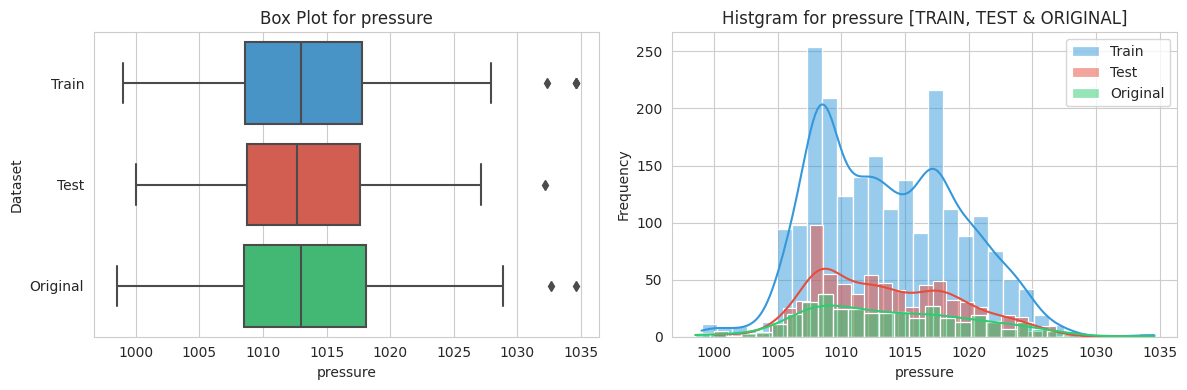

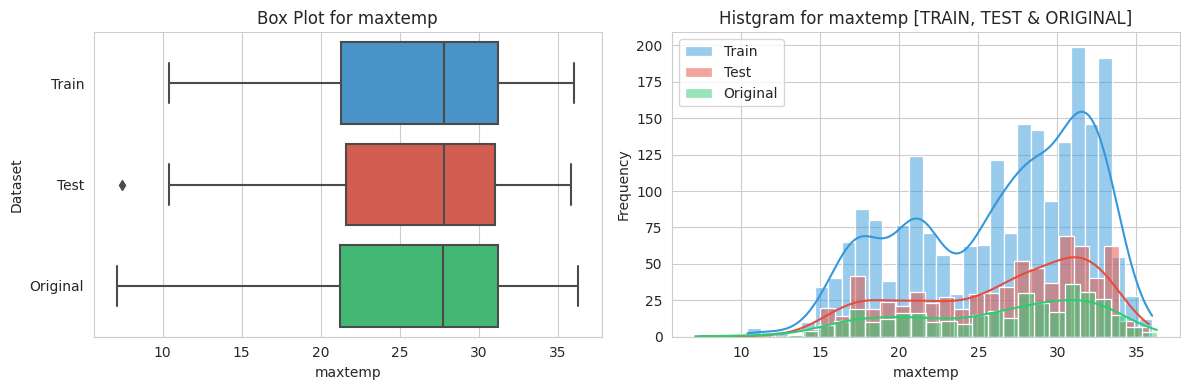

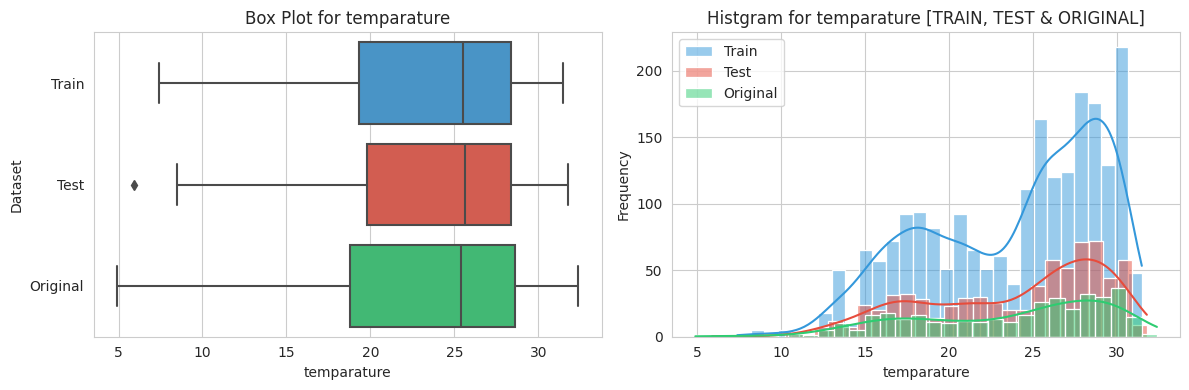

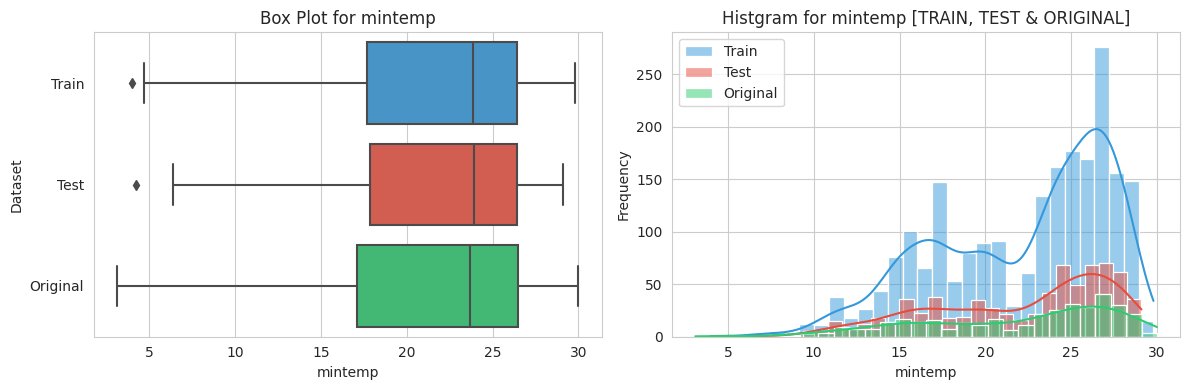

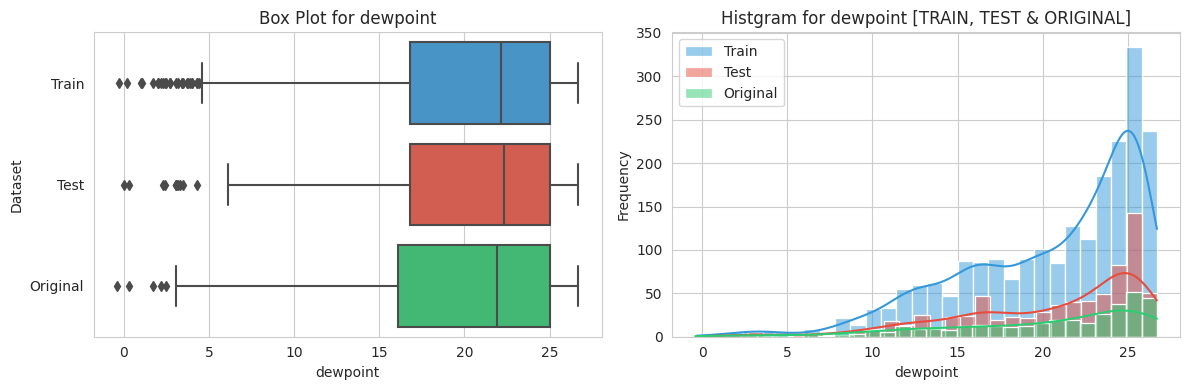

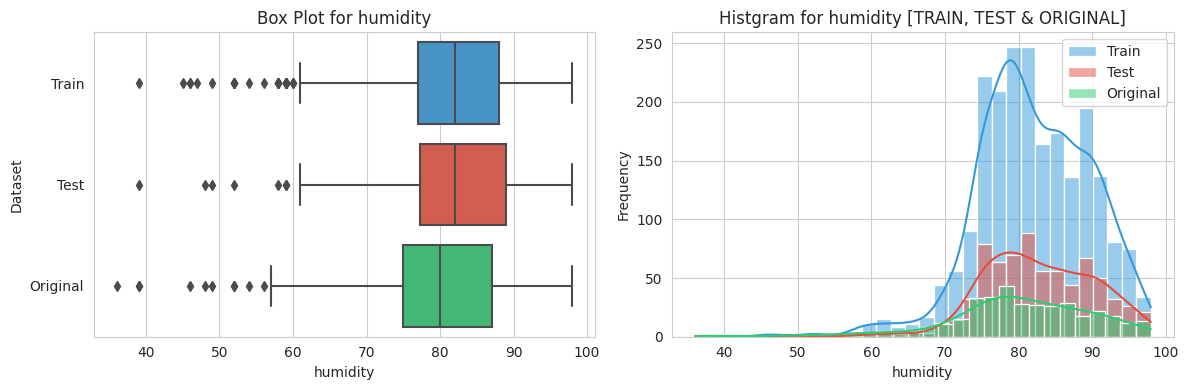

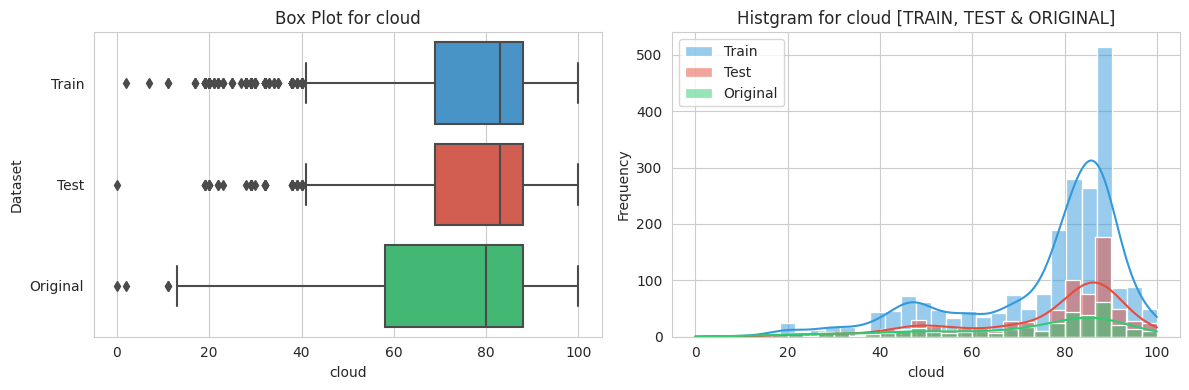

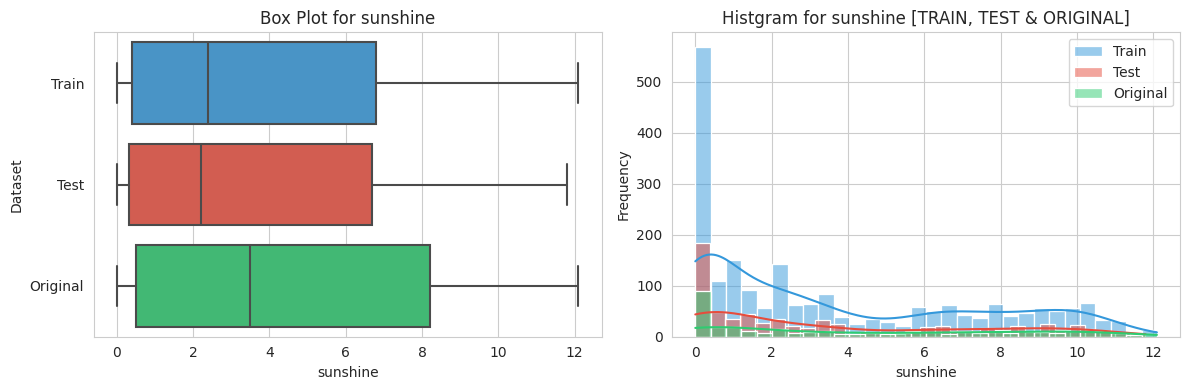

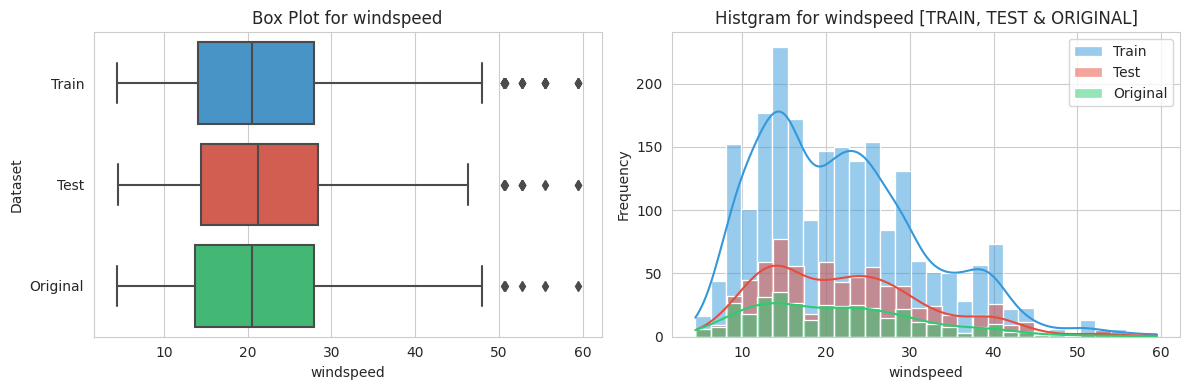

In [17]:
# データをとりあえず箱ひげ図とヒストグラムで図解
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# データセットカラムを加えて区別する(よくやる)
train_data["Dataset"] = "Train"
test_data["Dataset"] = "Test"
original_data["Dataset"] = "Original"

# 描画関数
def create_variable_plots(variable):
  sns.set_style("whitegrid")
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  
  # 箱ひげの方
  plt.subplot(1, 2, 1)
  sns.boxplot(data=pd.concat([train_data, test_data, original_data.dropna()]), x=variable, y="Dataset", palette=custom_palette)
  plt.xlabel(variable)
  plt.title(f"Box Plot for {variable}")
  
  # ヒストグラムの方
  plt.subplot(1, 2, 2)
  sns.histplot(data=train_data, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
  sns.histplot(data=test_data, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
  sns.histplot(data=original_data.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
  plt.xlabel(variable)
  plt.ylabel("Frequency")
  plt.title(f"Histgram for {variable} [TRAIN, TEST & ORIGINAL]")
  plt.legend() # 定義するときに付けたlebelから凡例を作る 
  
  # サブプロット同士のスペースを調整
  plt.tight_layout()
  
  plt.show()
  
for variable in numerical_variables:
  create_variable_plots(variable)

# Datasetカラムを落とす
train_data.drop("Dataset", axis=1, inplace=True)
test_data.drop("Dataset", axis=1, inplace=True)
original_data.drop("Dataset", axis=1, inplace=True)  
  

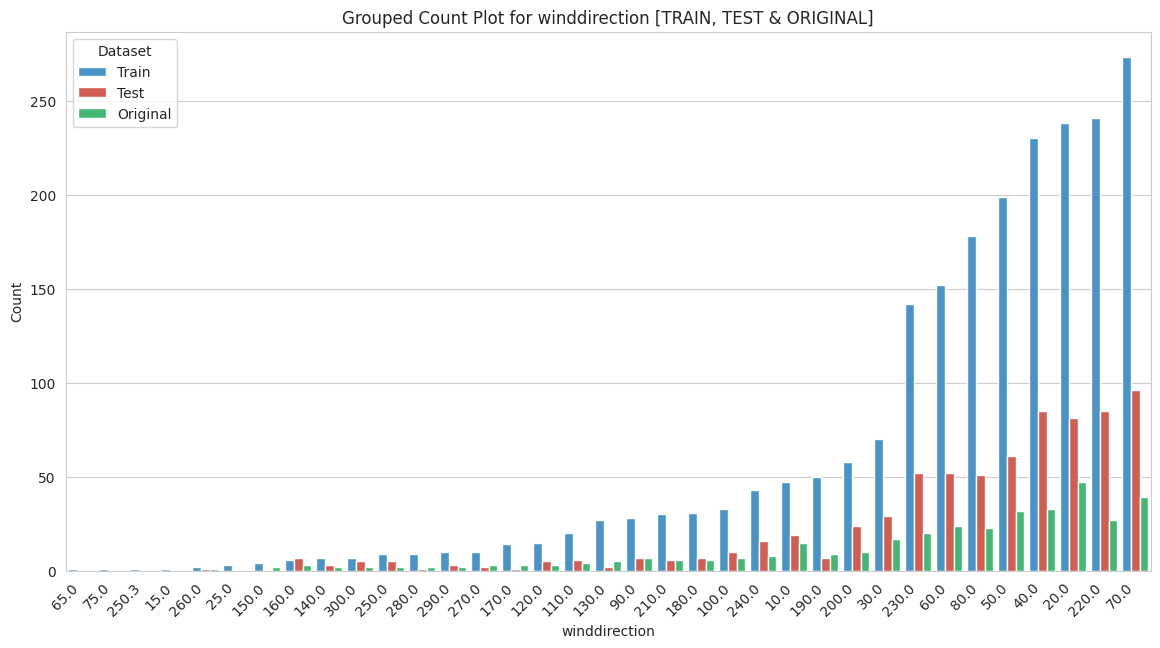

In [18]:
def create_categorical_barplot(variable):
  sns.set_style("whitegrid")
  
  train_data_copy = train_data.copy()
  test_data_copy = test_data.copy()
  original_data_copy = original_data.dropna().copy()
  
  train_data_copy["Dataset"] = "Train"
  test_data_copy["Dataset"] = "Test"
  original_data_copy["Dataset"] = "Original"
  
  combined_data = pd.concat([train_data_copy, test_data_copy, original_data_copy])
  
  # index(数値)ごとの数を集計してソート、最後にそのindexの方を返してリスト化
  train_counts = train_data[variable].value_counts().sort_values(ascending=True).index.tolist()
  
  plt.figure(figsize=(14, 7))
  sns.countplot(
    data=combined_data,
    x=variable,
    hue="Dataset",
    palette=custom_palette,
    dodge=True,
    width=0.85,
    order=train_counts
  )
  
  plt.ylabel("Count")
  plt.xlabel(variable)
  plt.title(f"Grouped Count Plot for {variable} [TRAIN, TEST & ORIGINAL]")
  plt.legend(title="Dataset")
  
  # xlabelが見にくいから回転
  plt.xticks(rotation=45, ha="right")
  
  plt.show()

for variable in categorical_variables:
  create_categorical_barplot(variable)

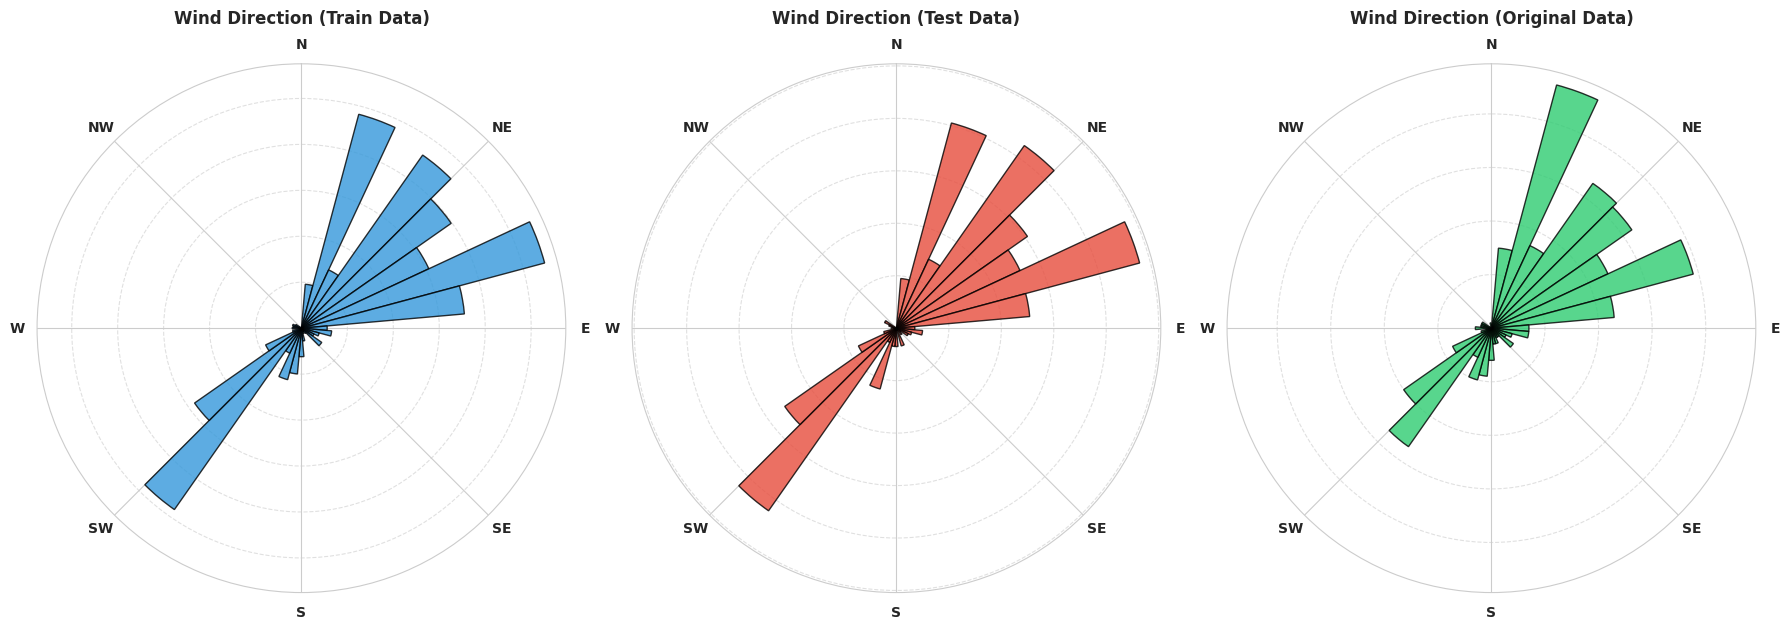

In [19]:
# 風向きを知るために円グラフに描画してみる

def create_wind_rose(ax, data, dataset_name, color):
  wind_direction_radians = np.radians(data["winddirection"].dropna())
  bins = np.linspace(0, 2*np.pi, 37)
  counts, bin_edges = np.histogram(wind_direction_radians, bins=bins)
  
  bars = ax.bar(bin_edges[:-1], counts, width=np.radians(10), color=color, edgecolor="black", alpha=0.8)
  
  ax.set_theta_zero_location("N")
  ax.set_theta_direction(-1) # 時計回り
  ax.set_xticks(np.radians(np.arange(0, 360, 45)))
  ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'], fontsize=10, fontweight='bold')
  
  ax.yaxis.grid(True, linestyle="--", alpha=0.6)
  ax.set_yticklabels([])
  ax.set_title(f"Wind Direction ({dataset_name})", fontsize=12, fontweight="bold", pad=10)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={"projection":"polar"})

create_wind_rose(axes[0], train_data, "Train Data", custom_palette[0])
create_wind_rose(axes[1], test_data, "Test Data", custom_palette[1])
create_wind_rose(axes[2], original_data.dropna(), "Original Data", custom_palette[2])

plt.tight_layout()
plt.show()

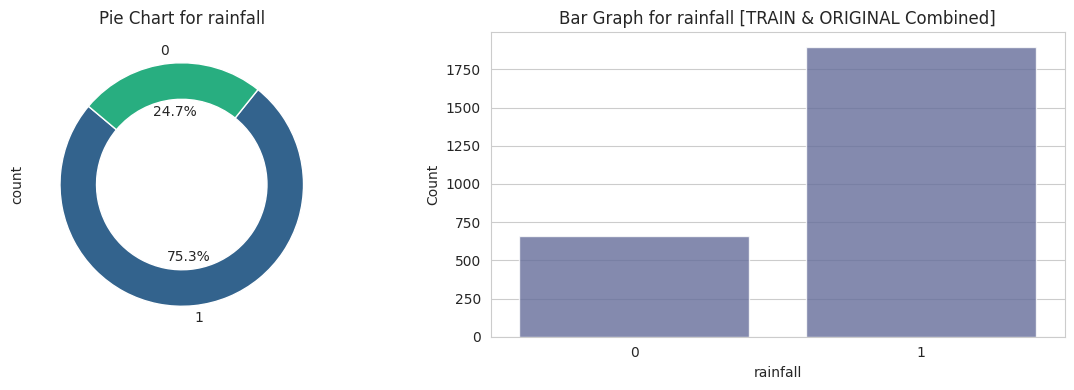

In [20]:
pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']
countplot_color = '#5C67A3'

# 目的変数をプロットして分布見る
def create_target_plots(variable):
  sns.set_style("whitegrid")
  
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  
  # 円グラフ
  plt.subplot(1, 2, 1)
  train_data[variable].value_counts().plot.pie(
    autopct="%1.1f%%", colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
  )
  plt.title(f"Pie Chart for {variable}")
  
  # 棒グラフ
  plt.subplot(1, 2, 2)
  sns.countplot(
    data=pd.concat([train_data, original_data.dropna()]),
    x=variable,
    color=countplot_color,
    alpha=0.8 # alphaは不透明度
  )
  plt.xlabel(variable)
  plt.ylabel("Count")
  plt.title(f"Bar Graph for {variable} [TRAIN & ORIGINAL Combined]")
  
  plt.tight_layout()
  plt.show()
  
create_target_plots(target_variable)

In [21]:
"""
つまり雨の日のデータが多いから、偏った結果になる
雨の日に向かってデータが歪んでるからそれを修正しないと雨じゃない日の予測が困難になる
"""

'\nつまり雨の日のデータが多いから、偏った結果になる\n雨の日に向かってデータが歪んでるからそれを修正しないと雨じゃない日の予測が困難になる\n'

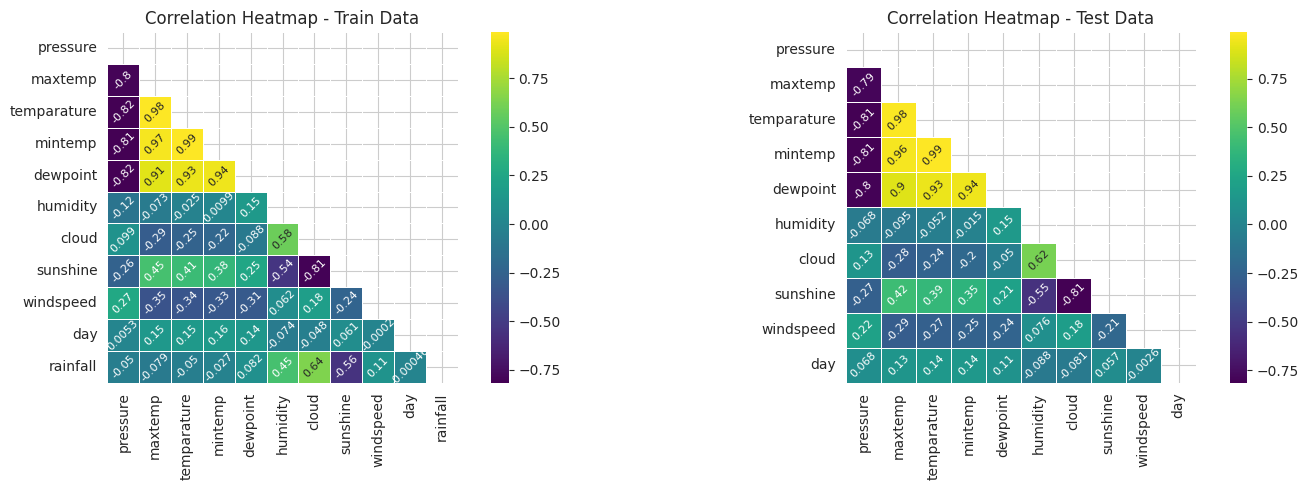

In [22]:
variables = [col for col in train_data.columns if col in numerical_variables] + ["day"]

test_variables = variables
train_variables = variables + ["rainfall"]

corr_train = train_data[train_variables].corr()
corr_test = test_data[test_variables].corr()

# 下三角形にする
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

annot_kws = {"size": 8, "rotation": 45}

# Trainのヒートマップ
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap="viridis", annot=True,
                       square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title("Correlation Heatmap - Train Data")

# Testのヒートマップ
plt.subplot(1, 2, 2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap="viridis", annot=True,
                      square=True, linewidths=.5,xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title("Correlation Heatmap - Test Data")

plt.tight_layout()

plt.show()

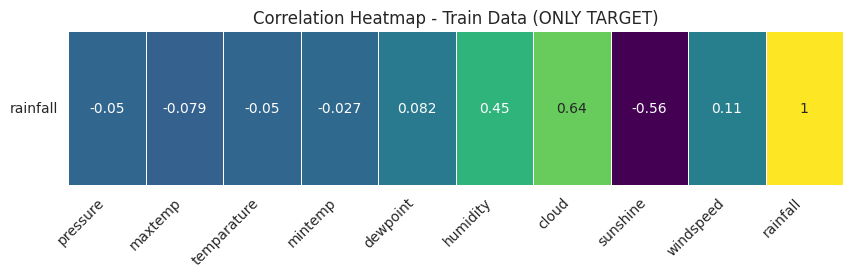

In [24]:
variables = [col for col in train_data.columns if col in numerical_variables]
train_variables = variables + ["rainfall"]

# rainfallとの相関だけを計算する
corr_train = train_data[train_variables].corr()[["rainfall"]].T # 水平のグラフにするため転置
annot_kws = {"size": 10}

plt.figure(figsize=(10, 2))
ax_train = sns.heatmap(corr_train, cmap="viridis", annot=True,
                       square=False, linewidths=0.5, annot_kws=annot_kws,
                       cbar=False) # 右のカラーバー削除

plt.xticks(rotation=45, ha="right")
plt.title("Correlation Heatmap - Train Data (ONLY TARGET)")
plt.yticks(rotation=0)

plt.show()


In [25]:
"""
このプロセスは欠損値埋めやデータの分布の調整、フューチャーエンコーディングしたときなどにもう一度行う。
指標として扱う
目的変数のみをグラフ化し、データ分布を確認することをUnivariate Analysis
説明変数同士、また目的変数との相関関係を確認することをBivariate Analysis
"""


'\nこのプロセスは欠損値埋めやデータの分布の調整、フューチャーエンコーディングしたときなどにもう一度行う。\n指標として扱う\n'

In [26]:
# ここまででわかったことは気温が最高気温と最低気温と露点がめちゃくちゃ相関が高い(当たり前)こと
# つまり気温が分かれば他の特徴がわかるわけだから、冗長なことになってる

# 目的変数に対して影響度が高い特徴としてcloudとsunshineがある。あとhumidity
# pressureとwindspeedはそこそこの相関

# rainfallとdayはマジで関係なさそう
# つまりシーズンの問題


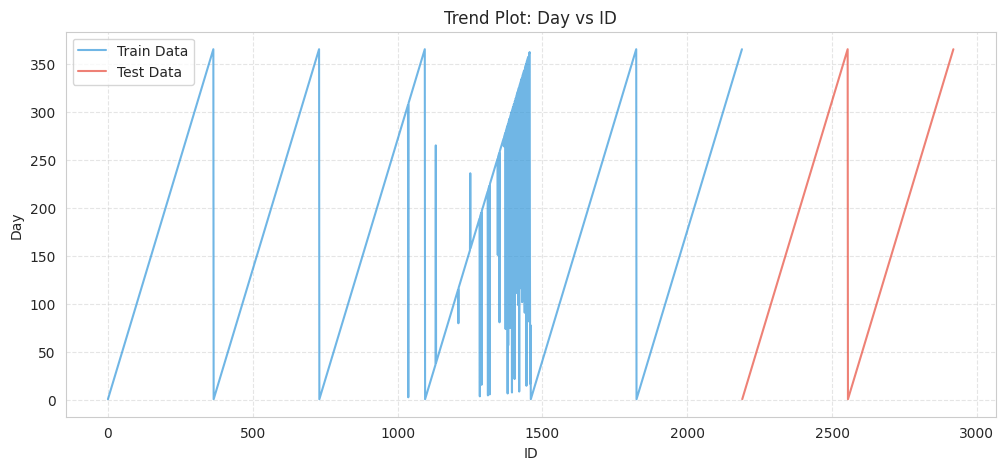

In [27]:
# 線グラフでtrainとtestのdayの分布を見る
train_color = '#3498db'  # Blue
test_color = '#e74c3c'   # Red

plt.figure(figsize=(12, 5))

plt.plot(train_data["id"], train_data["day"], linestyle="-", color=train_color, label="Train Data", alpha=0.7)
plt.plot(test_data["id"], test_data["day"], linestyle="-", color=test_color, label="Test Data", alpha=0.7)

plt.xlabel("ID")
plt.ylabel("Day")
plt.title("Trend Plot: Day vs ID")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [29]:
# リピートのパターンを予測して出力する
# パターンは365日を6年繰り返す
expected_pattern = np.tile(np.arange(1, 366), 6)

train_data["expected_day"] = expected_pattern[:len(train_data)]
train_data["day_mismatch"] = train_data["day"] != train_data["expected_day"]

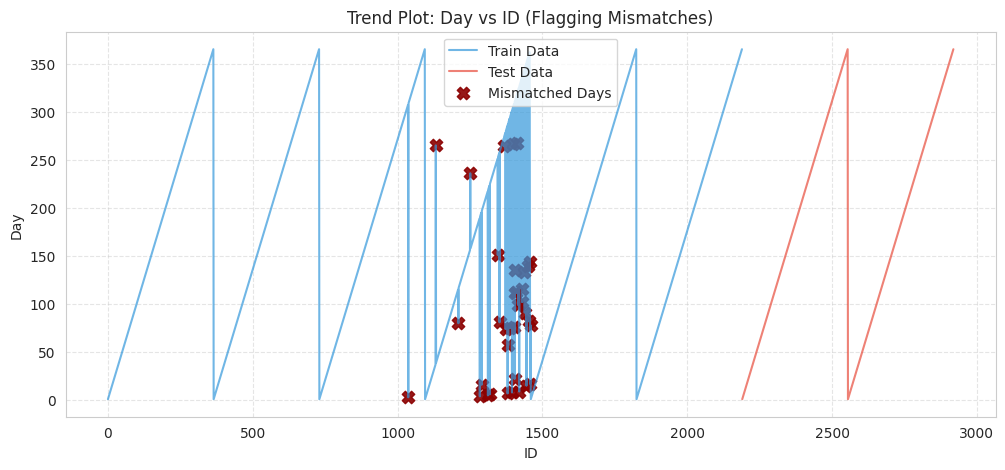

In [30]:
# dayがパターンに則っていない点にフラグを建てる
plt.figure(figsize=(12, 5))

plt.plot(train_data["id"], train_data["day"], linestyle="-", color=train_color, label="Train Data", alpha=0.7)
plt.plot(test_data["id"], test_data["day"], linestyle="-", color=test_color, label="Test Data", alpha=0.7)

plt.scatter(
  train_data.loc[train_data["day_mismatch"], "id"],
  train_data.loc[train_data["day_mismatch"], "day"],
  color="#8B0000", marker="X", s=80, label="Mismatched Days", alpha=0.9
)

plt.xlabel("ID")
plt.ylabel("Day")
plt.title("Trend Plot: Day vs ID (Flagging Mismatches)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

In [31]:
# まあくしゃくしゃになってるから直そうという話

In [33]:
train_data["day"] = train_data["expected_day"]

last_train_day = train_data["day"].iloc[-1]

test_data["day"] = np.arange(last_train_day + 1, last_train_day + 1 + len(test_data)) # なんで？

train_data.drop(columns=["expected_pattern", "day_mismatch"], errors="ignore", inplace=True)

In [39]:
last_train_day
test_data["day"].dtype

dtype('int64')

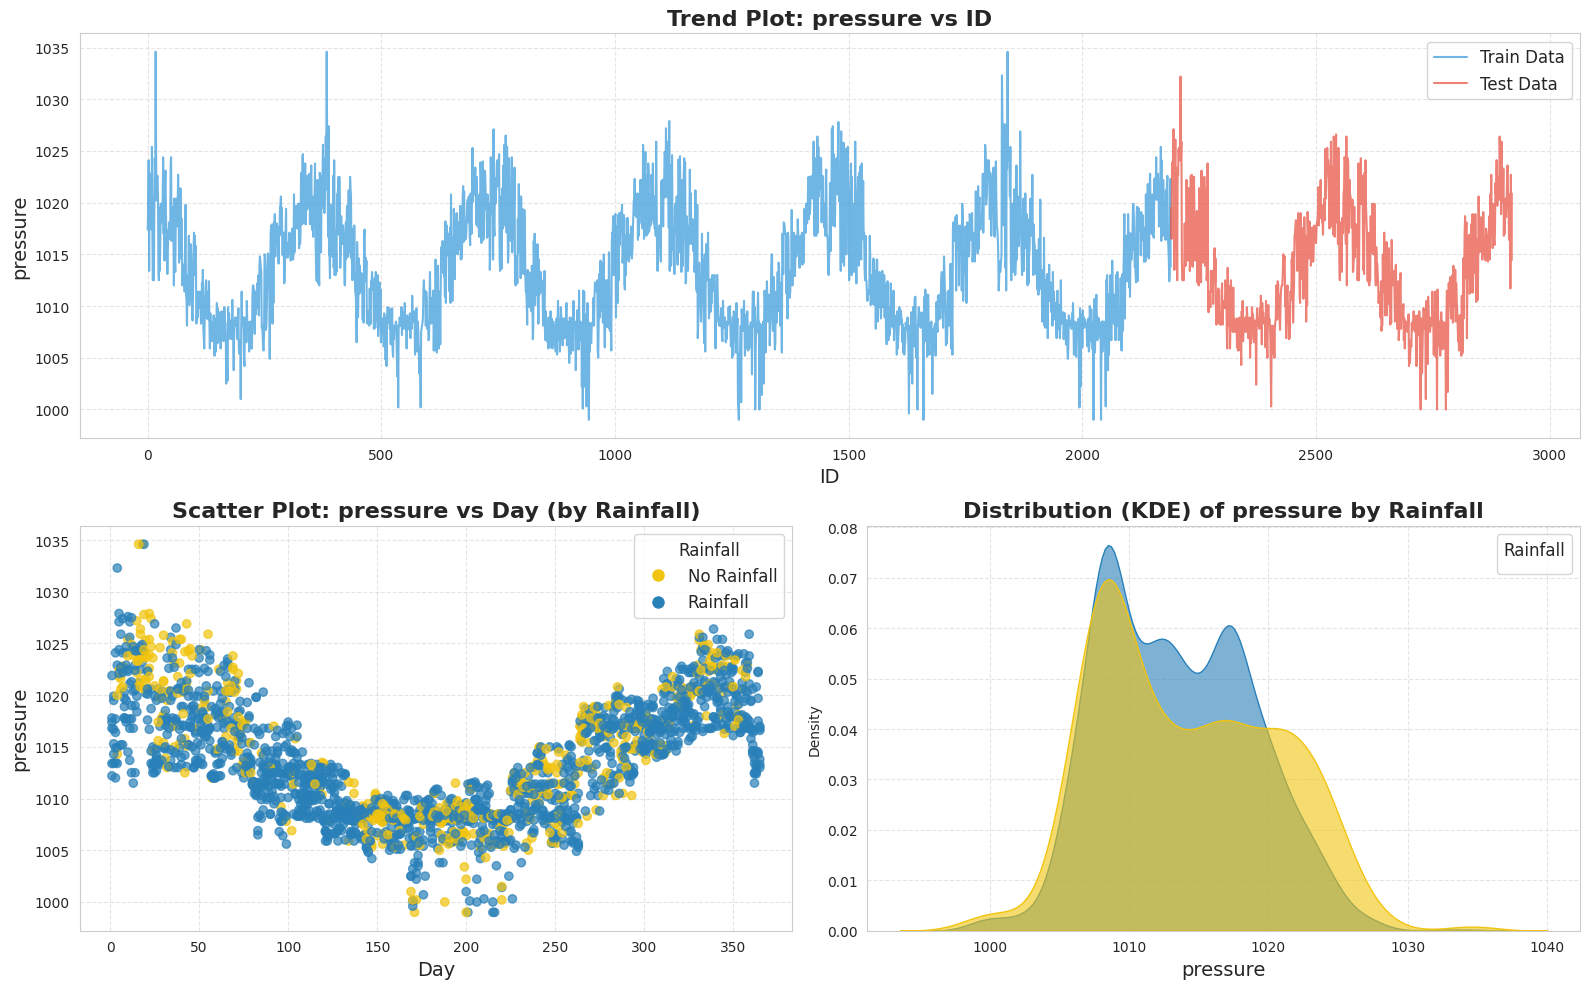

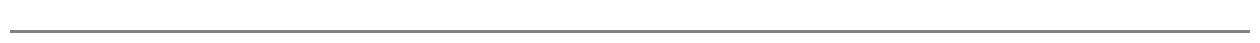

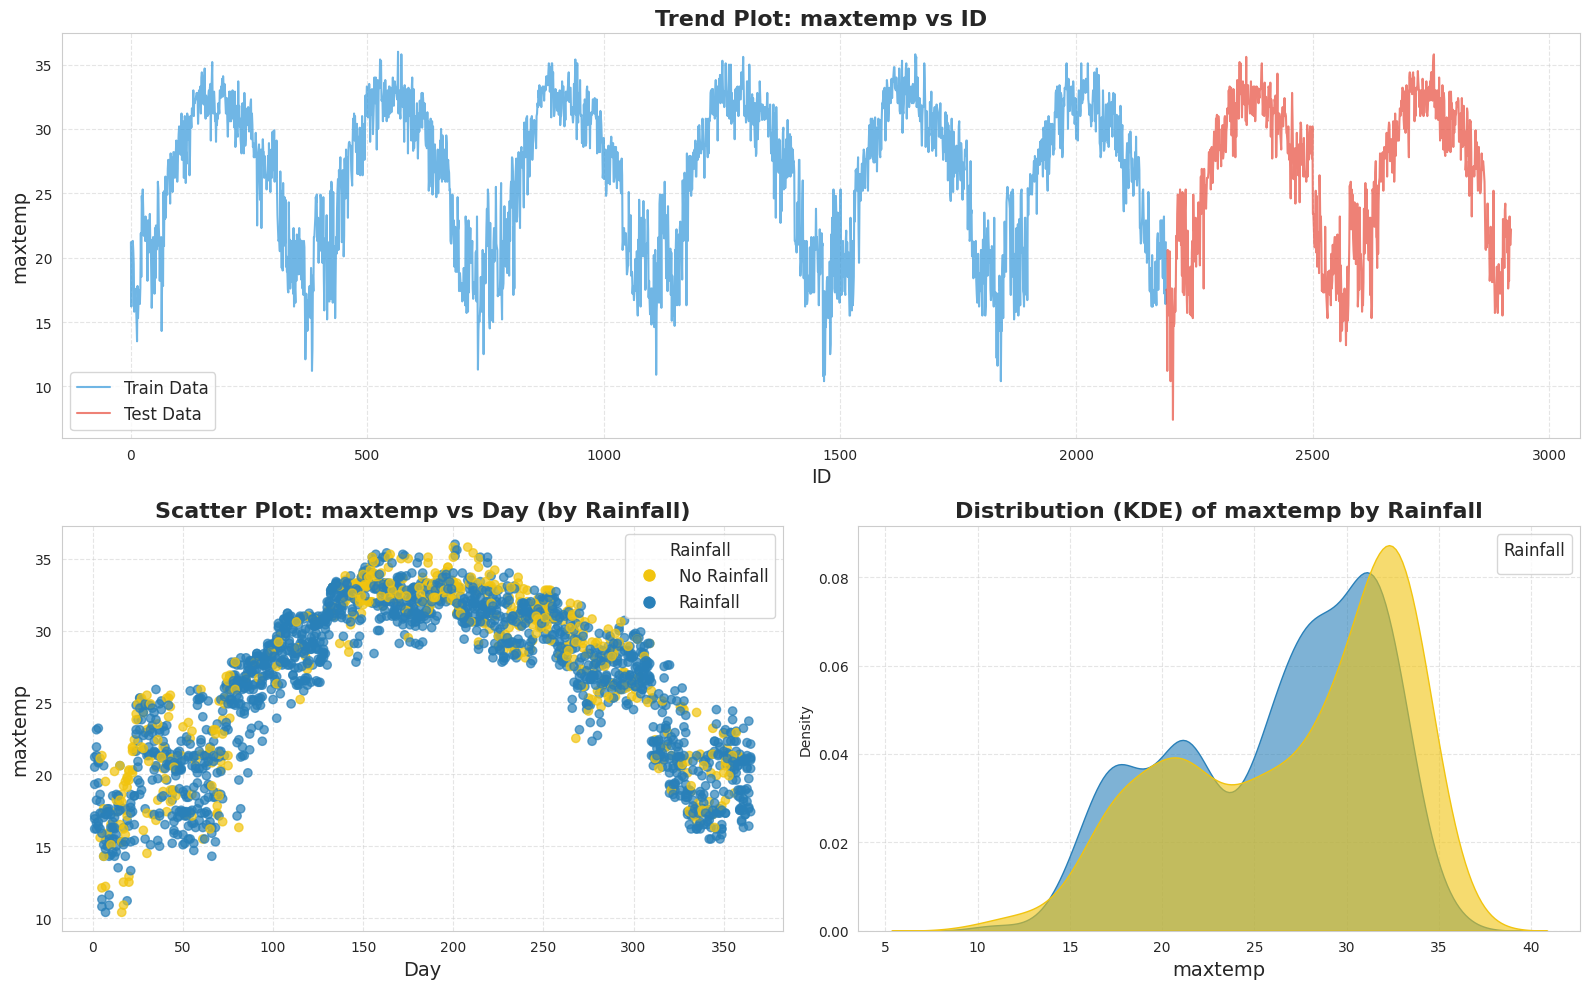

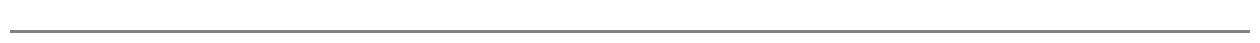

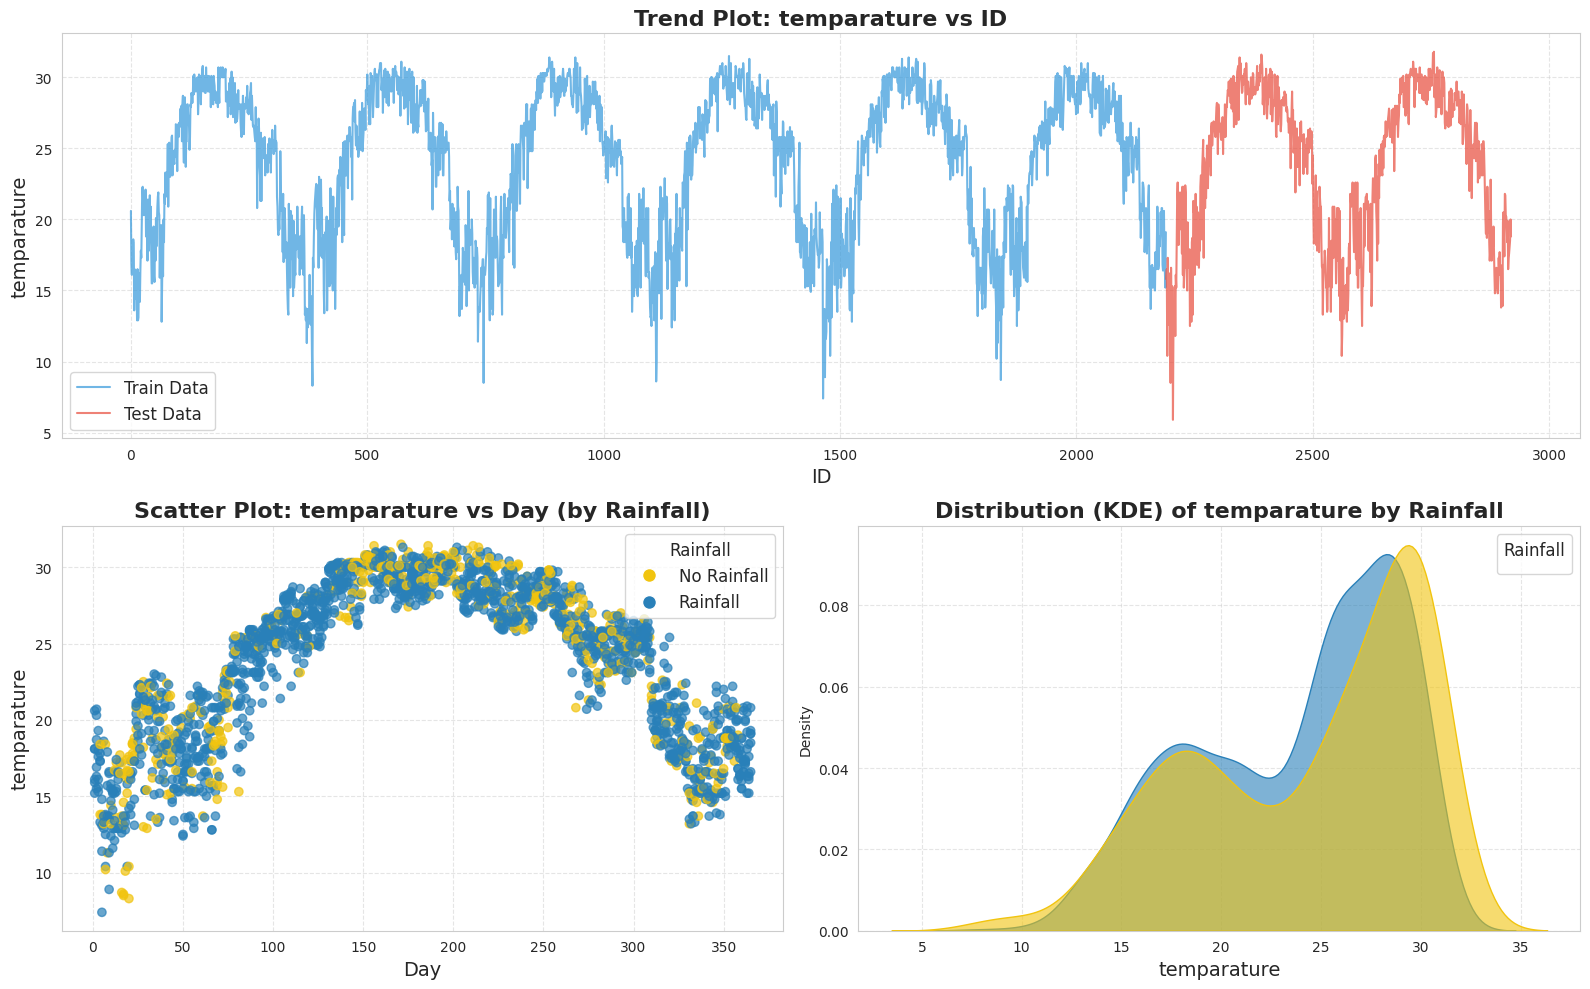

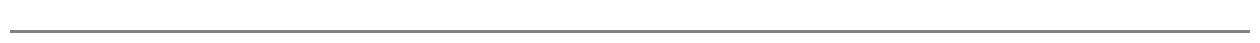

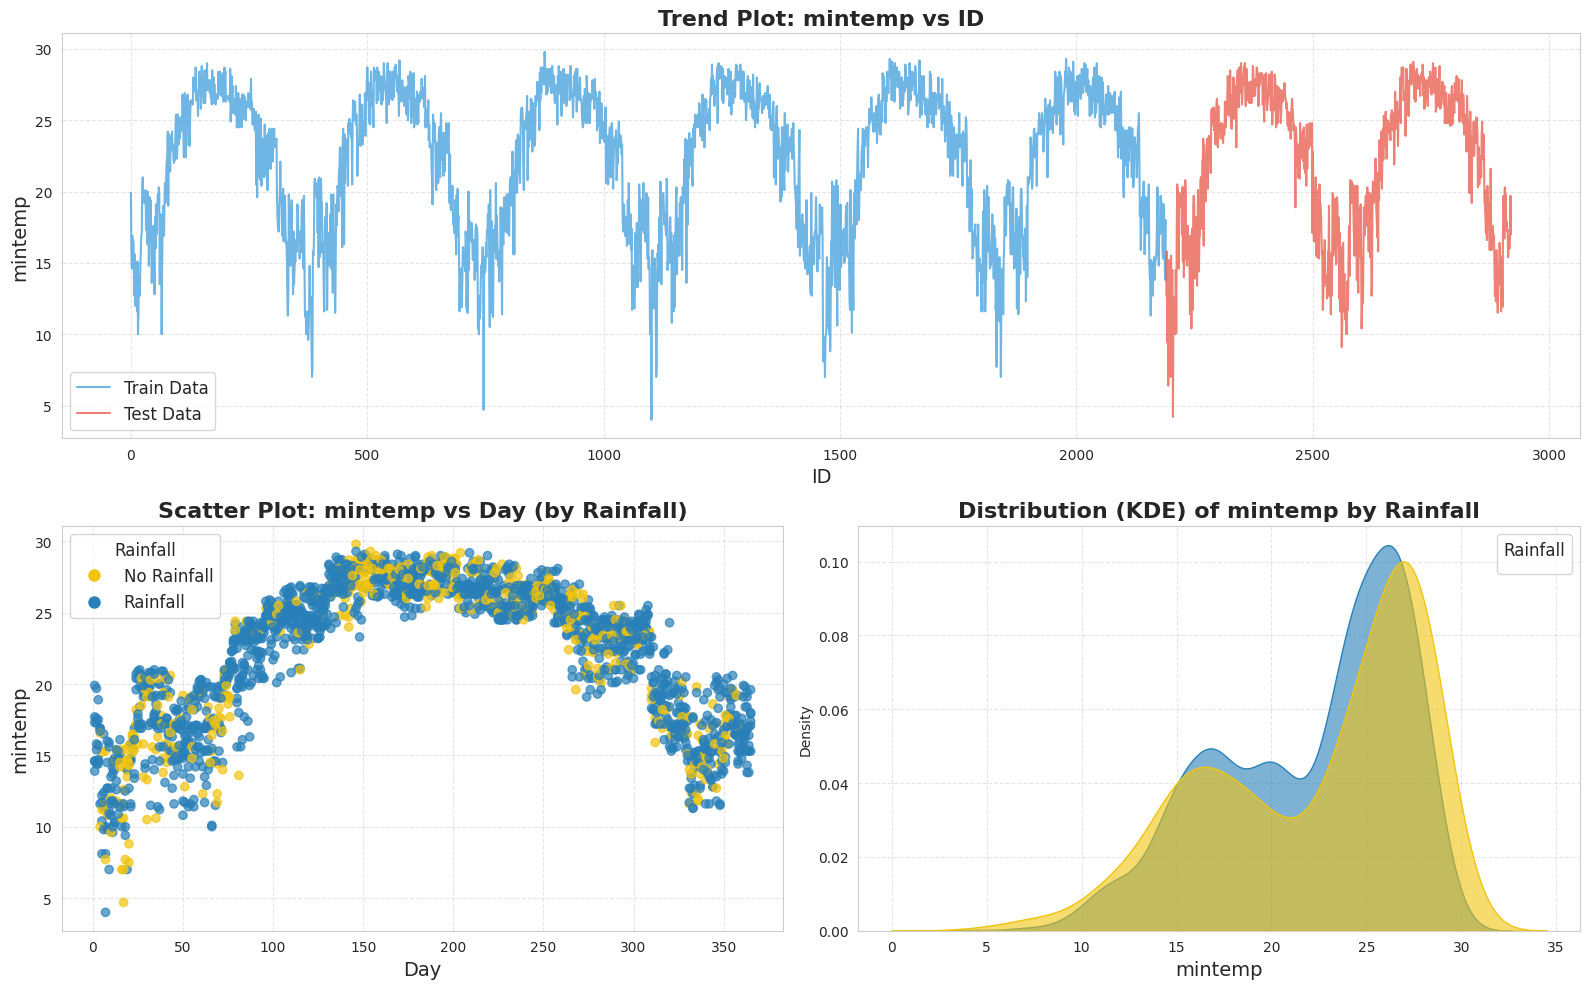

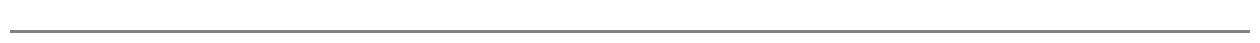

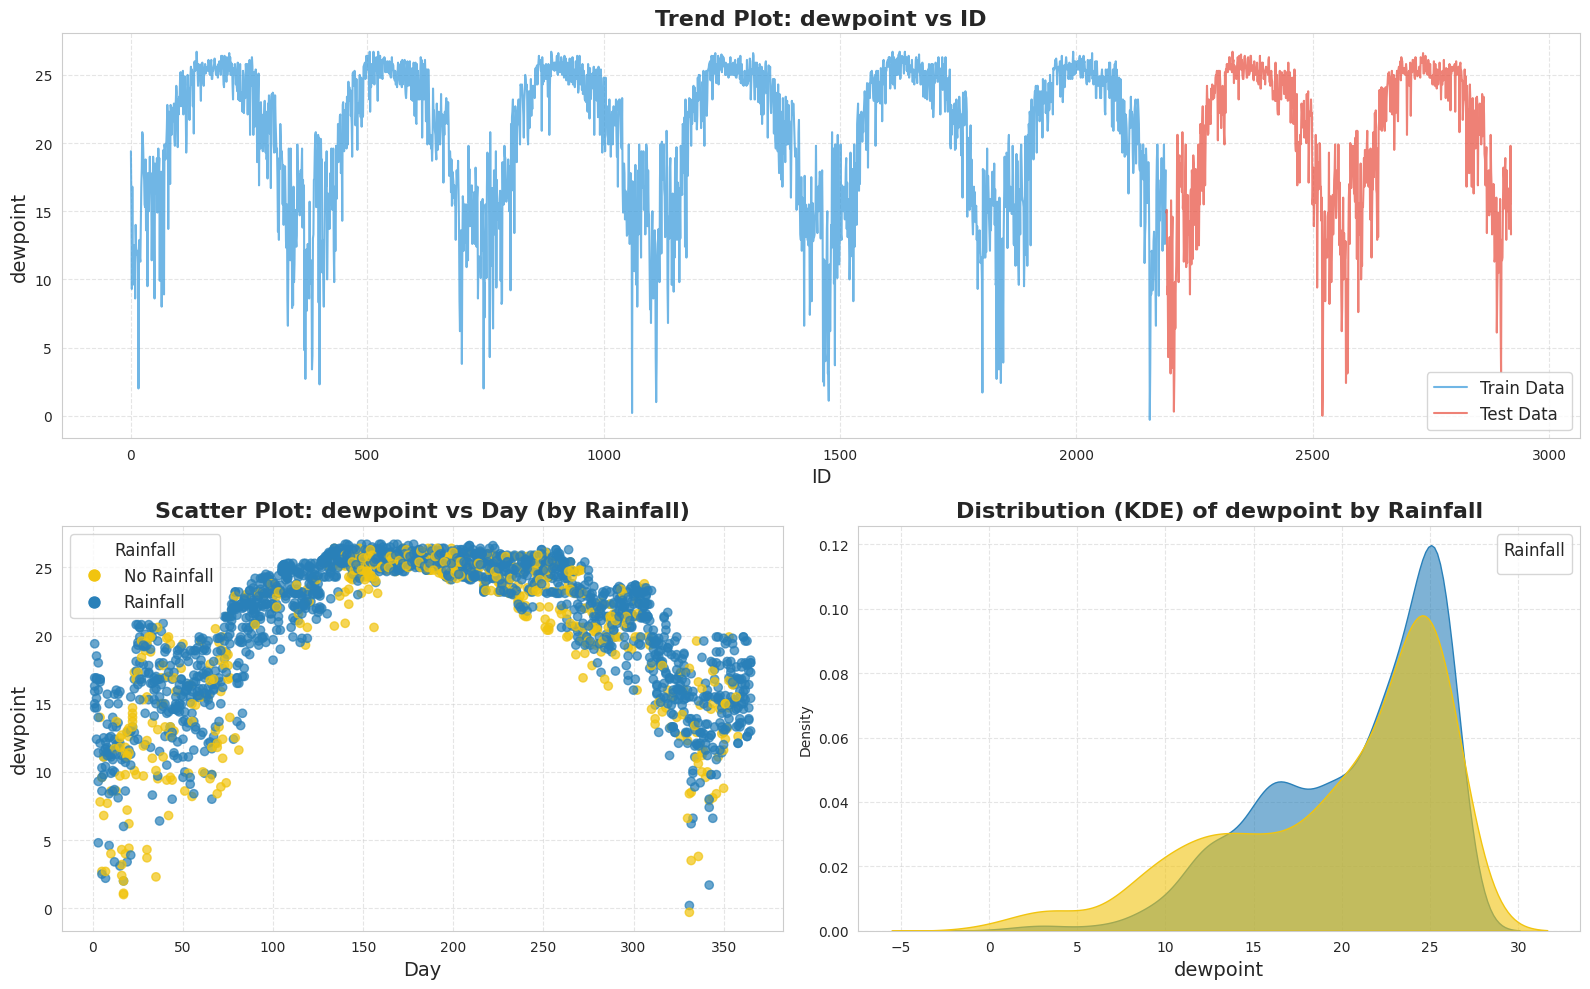

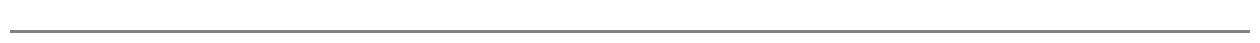

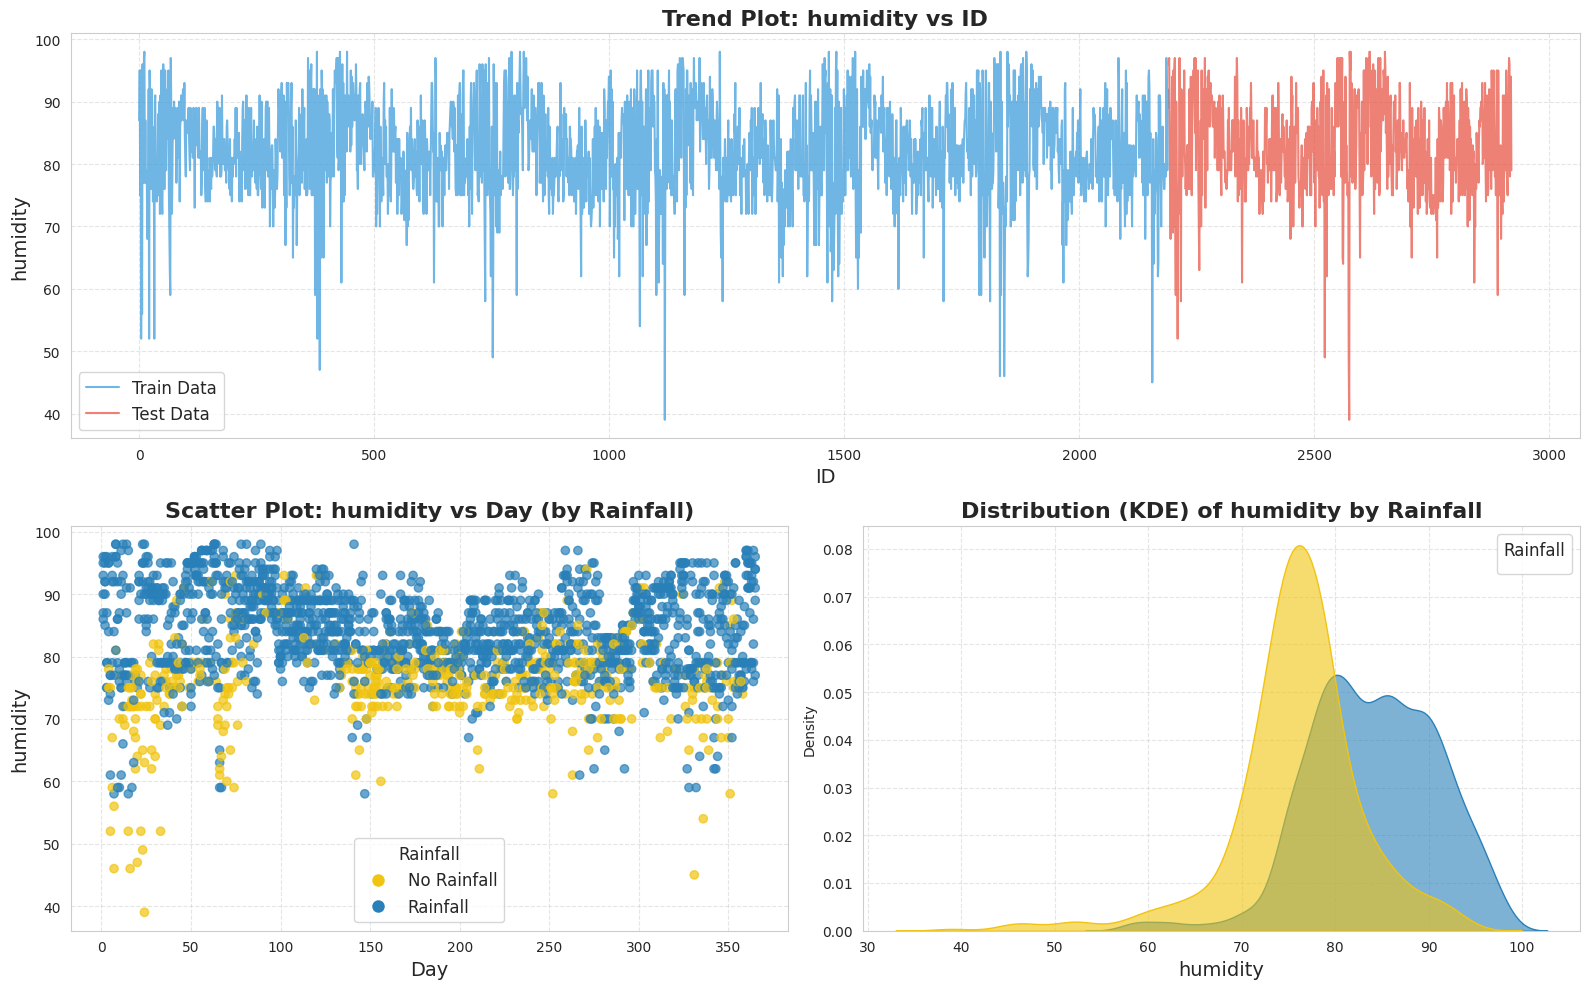

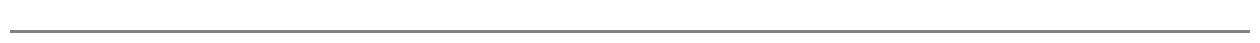

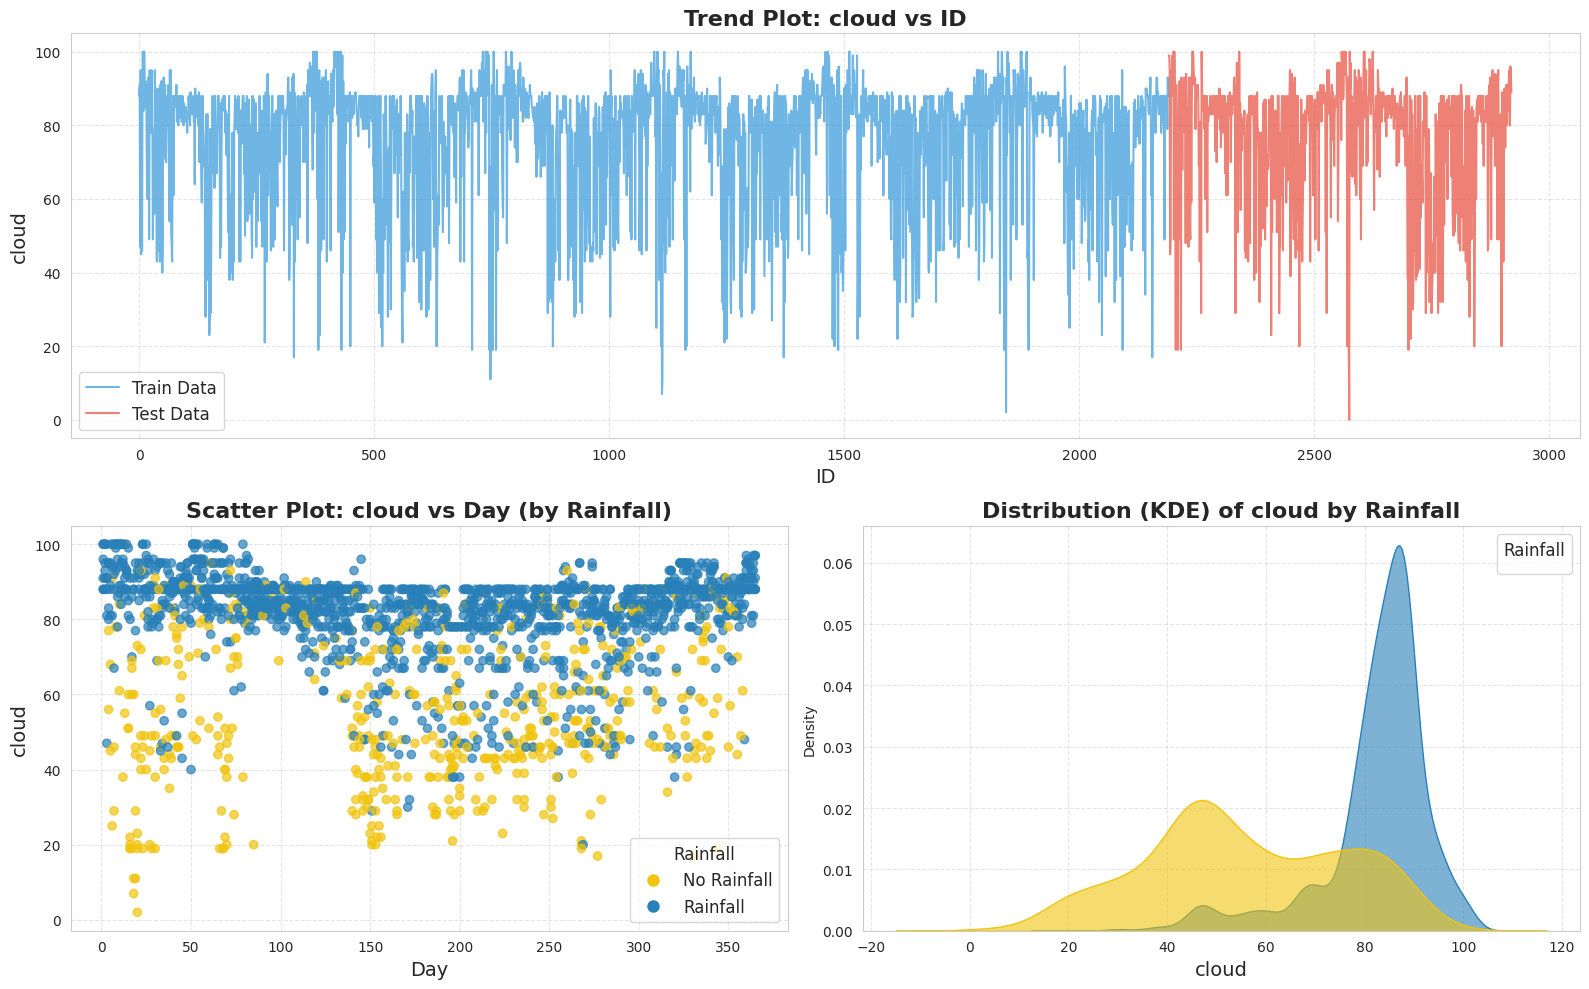

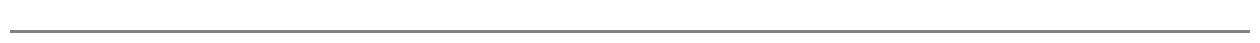

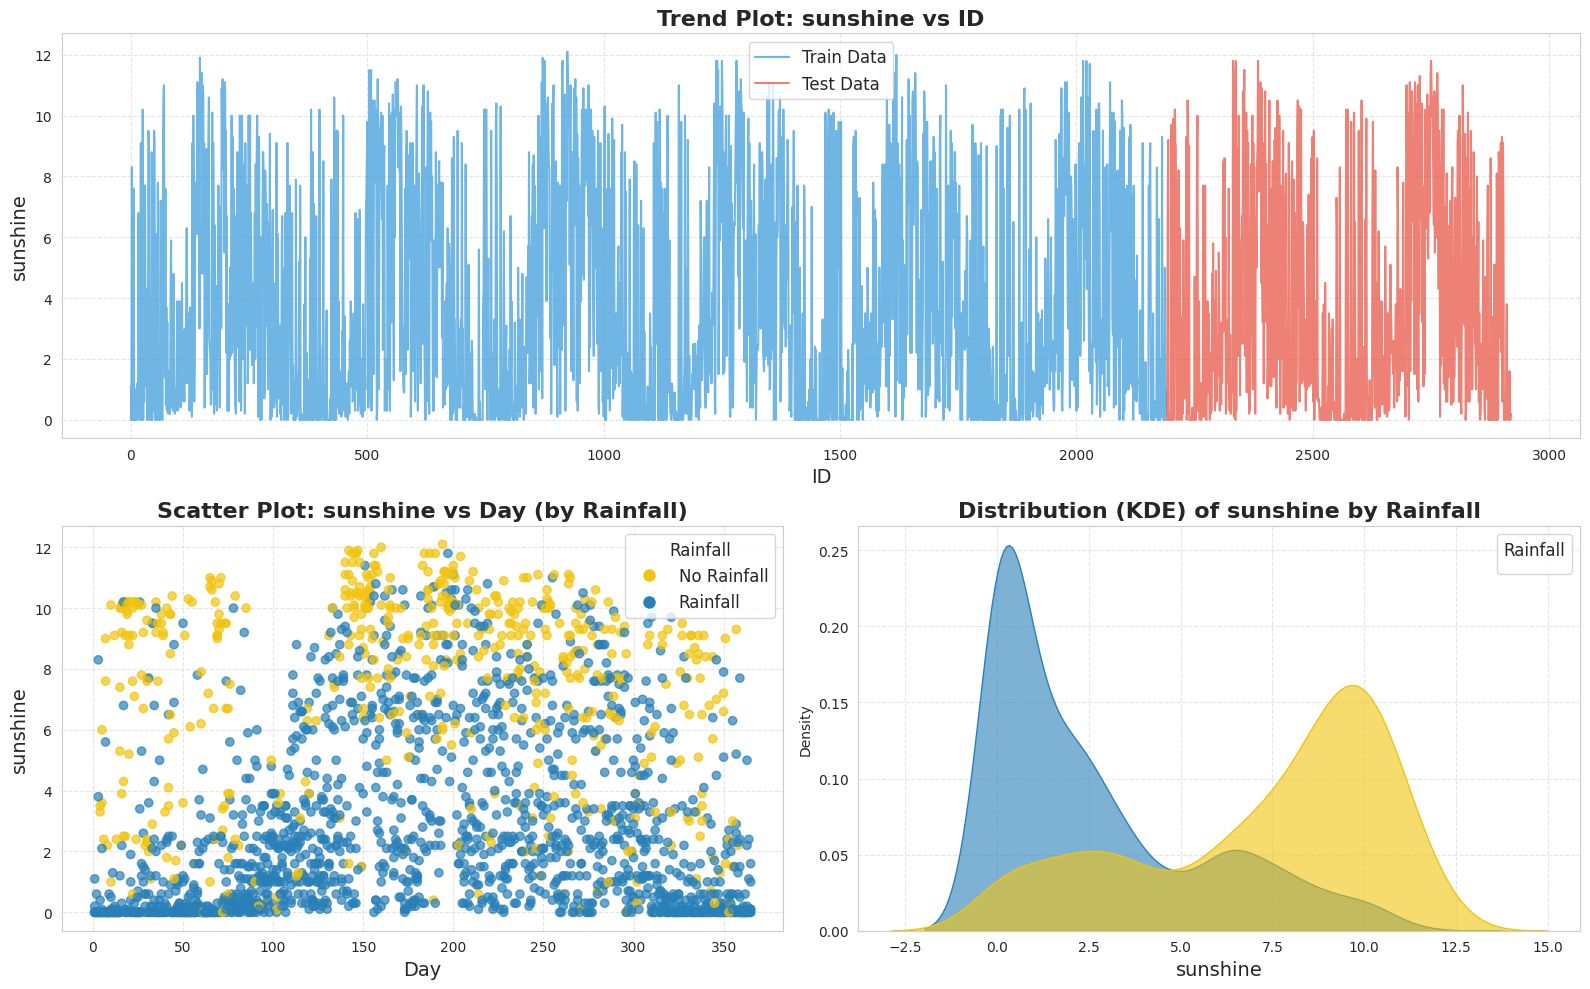

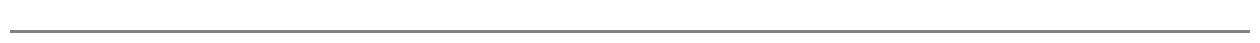

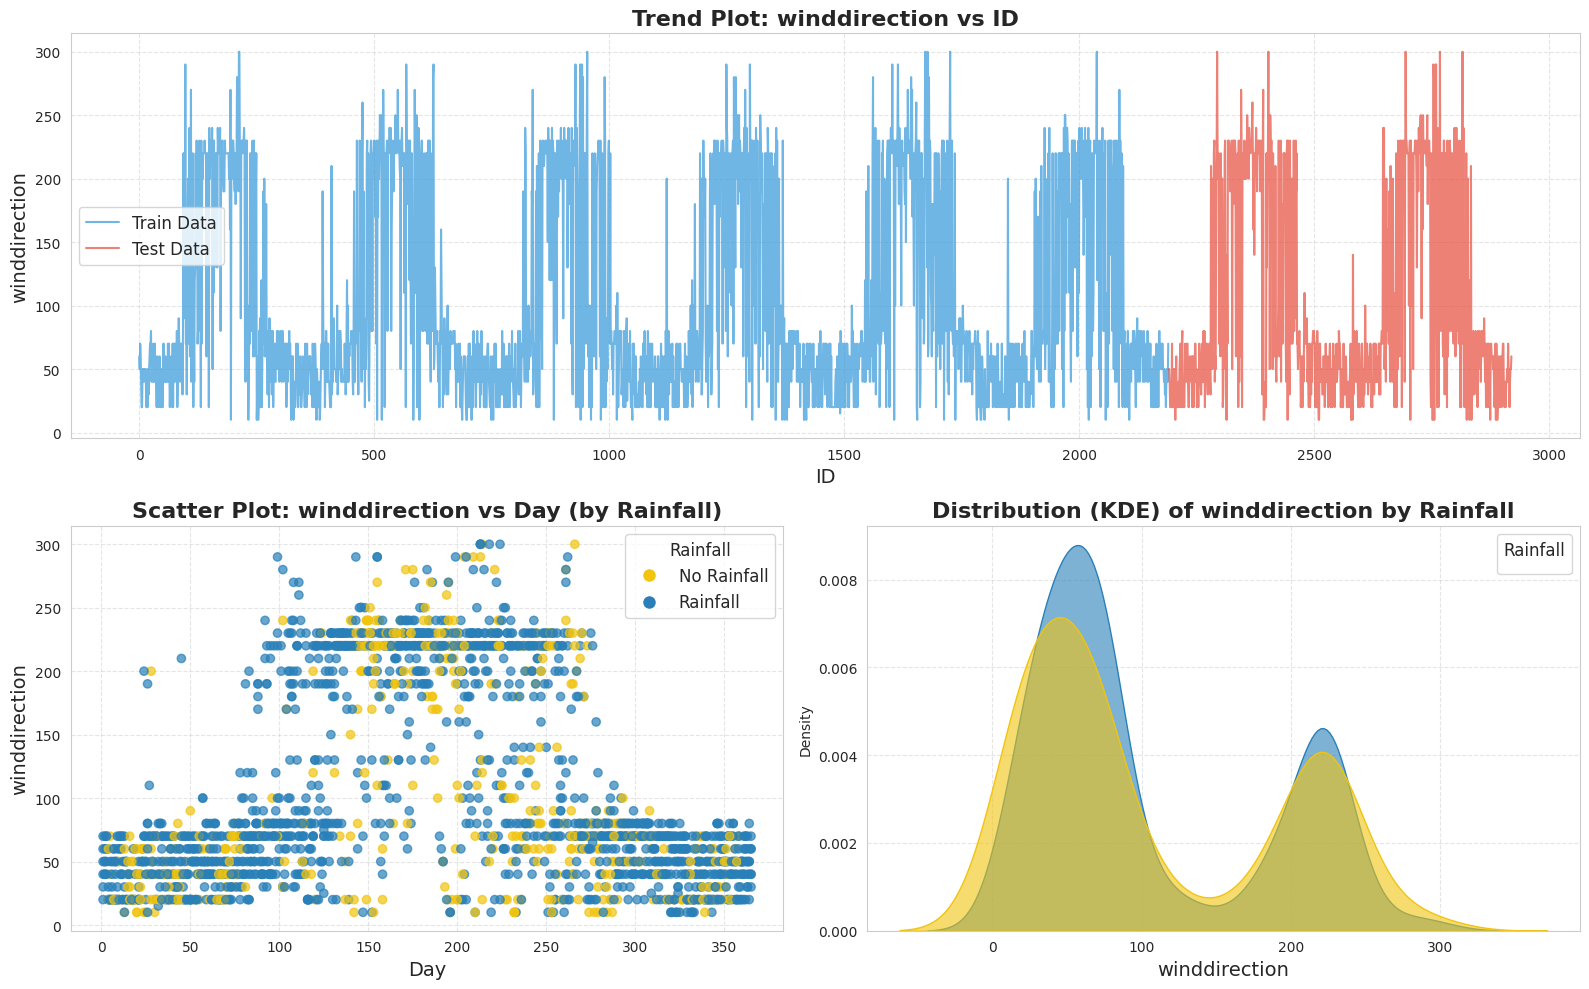

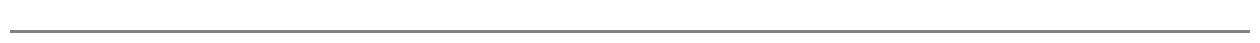

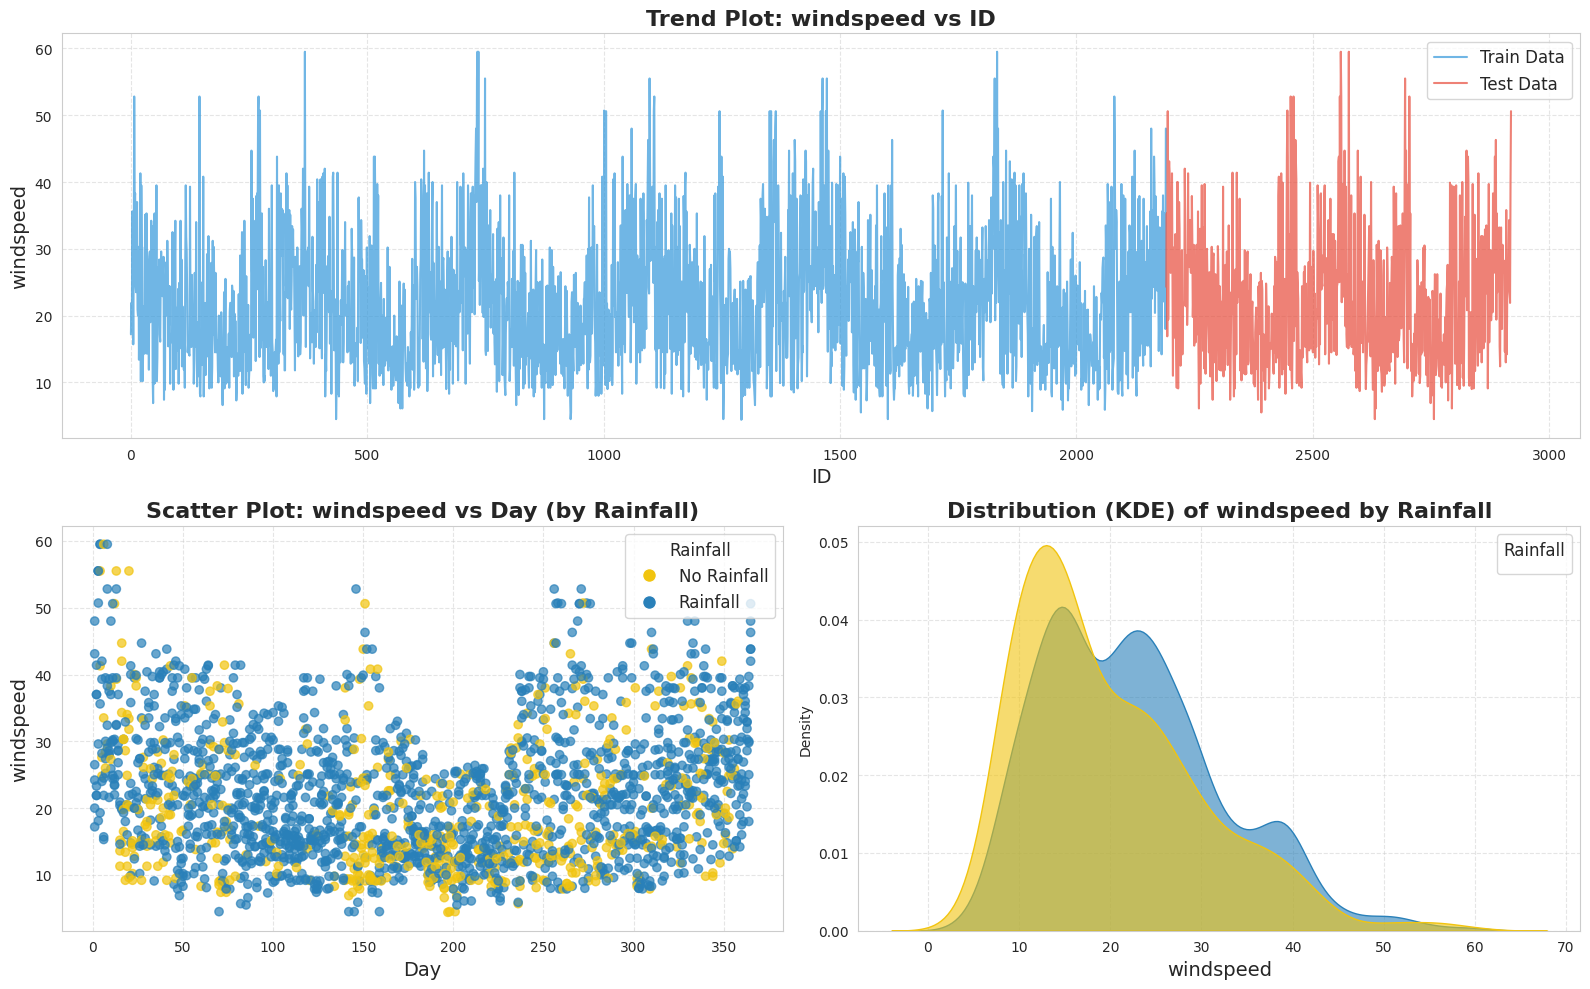

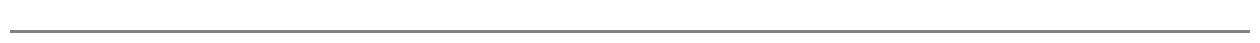

In [42]:
rainfall_colors = {0: '#f1c40f', 1: '#2980b9'}
numerical_columns = test_data.select_dtypes(include=["int64", "float64"]).columns.tolist()
for col in ["id", "day", "rainfall"]:
  if col in numerical_columns:
    numerical_columns.remove(col)

for column in numerical_columns:
  # とりあえず各カラムとID(時間)との比較
  fig = plt.figure(figsize=(16, 10))
  gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])
  
  ax0 = fig.add_subplot(gs[0, :])
  ax0.plot(train_data["id"], train_data[column], linestyle="-", color=train_color, label="Train Data", alpha=0.7)
  ax0.plot(test_data["id"], test_data[column], linestyle="-", color=test_color, label="Test Data", alpha=0.7)
  
  ax0.set_xlabel("ID", fontsize=14)
  ax0.set_ylabel(column, fontsize=14)
  ax0.set_title(f"Trend Plot: {column} vs ID", fontsize=16, fontweight="bold")
  ax0.legend(fontsize=12)
  ax0.grid(True, linestyle="--", alpha=0.5)
  
  # 次にその関係に目的変数がどう絡むかをプロットして確認
  ax1 = fig.add_subplot(gs[1, 0])
  scatter = ax1.scatter(
    train_data["day"], train_data[column],
    c=train_data["rainfall"].map(rainfall_colors), alpha=0.7
  )
  ax1.set_xlabel("Day", fontsize=14)
  ax1.set_ylabel(column, fontsize=14)
  ax1.set_title(f"Scatter Plot: {column} vs Day (by Rainfall)", fontsize=16, fontweight="bold")
  
  # legendの加工
  from matplotlib.lines import Line2D
  legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="No Rainfall",
           markersize=10, markerfacecolor=rainfall_colors[0]),
    Line2D([0], [0], marker="o", color="w", label="Rainfall",
           markersize=10, markerfacecolor=rainfall_colors[1])
  ]
  ax1.legend(handles=legend_elements, title="Rainfall", fontsize=12, title_fontsize=12)
  ax1.grid(True, linestyle="--", alpha=0.5)
  
  ax2 = fig.add_subplot(gs[1, 1])
  sns.kdeplot(data=train_data, x=column, hue="rainfall", palette=rainfall_colors, ax=ax2, fill=True, common_norm=False, alpha=0.6)
  ax2.set_xlabel(column, fontsize=14)
  ax2.set_title(f"Distribution (KDE) of {column} by Rainfall", fontsize=16, fontweight="bold")
  ax2.legend(title="Rainfall", fontsize=12, title_fontsize=12)
  ax2.grid(True, linestyle="--", alpha=0.5)
  
  plt.tight_layout()
  plt.show()
  
  plt.figure(figsize=(16, 0.3))
  plt.axhline(y=0, color="gray", linewidth=5, linestyle="-")
  plt.axis("off")
  plt.show()

In [43]:
# 今回のEDAで見たいのは連続した時間の中で特徴がどういう動きをするのかと、目的変数が特徴に対してどういう分布になるのかを具体的に確認
# 雨が降った日と振ってない日で深度が離れているほど、目的変数を予測するのに利用できる特徴であることがわかる(まあ前の相関関係グラフでもわかってたことだけど)
# まあやっぱり湿度、雲の量、日光量とかは相関が高いという結果

In [44]:
# 欠損値埋め
test_data["winddirection"].fillna(test_data["winddirection"].median(), inplace=True)

In [ ]:
# Feature Engineering

# 風向きをセクター内にカテゴライズする
def wind_sector(direction):
  if pd.isna(direction):
    return np.nan # ここではいったん欠損値は保護
  direction = float(direction)
  if direction >= 315 or direction < 45:
    return "North"
  elif direction >= 45 and direction < 135:
    return "East"
  elif direction >= 135 and direction < 225:
    return "South"
  else:
    return "West"

def perform_feature_engineering(df):
  # 新しい特徴量の作成(いつもの手順)
  # 1. dayを季節的な特徴にするために終端と先端をつなげる非線形グラフにする
  df["day_sin"] = np.sin(2 * np.pi * df["day"] / 365)
  df["day_cos"] = np.cos(2 * np.pi * df["day"] / 365)
  
  # 2. キーバリューの前日の値も使う 1番上の値は0埋めする
  df["cloud_lag1"] = df["cloud"].shift(1).fillna(0)
  df["sunshine_lag1"] = df["sunshine"].shift(1).filna(0)
  df["humidity_lag1"] = df["humidity"].shift(1).fillna(0)
  
  # 3. 過去２日間と当日の３日間の平均を取る(この処理をローリングという) 上2つの値が空いてしまうので3つ目の値を入れる
  df["cloud_roll3_mean"] = df["cloud"].rolling(window=3, min_periods=1).mean().fillna(method="bfill")
  df["sunshine_roll3_mean"] = df["sunshine"].rolling(window=3, min_periods=1).mean().fillna(method="bfill")
  df["humidity_roll3_mean"] = df["humidity"].rolling(window=3, min_periods=1).mean().fillna(method="bfill")
  
  # 4. 強い相関関係のある特徴をくっつけて1つの特徴にする
  df["cloud_humidity"] = (df["cloud"] * df["humidity"]).fillna(0)
  df["sunshine_cloud_ratio"] = (df["sunshine"] / (df["cloud"] + 1e-5)).fillna(0)
  
  # 5. tempの値の範囲や、気圧の前日との差(diff)をデータフレームとして取る
  df["temp_range"] = (df["maxtemp"] - df["mintemp"]).fillna(df["maxtemp"].median())
  df["pressure_diff"] = df["pressure"].diff().fillna(0)
  
  # 6. 時間とキーバリューとの相関データフレーム作成
  df["cloud_day_sin"] = (df["cloud"] * df["day_sin"]).fillna(0)
  df["sunshine_day_cos"] = (df["cloud"] * df["day_cos"]).fillna(0)
  df["humidity_roll3_day_sin"] = (df["humidityroll3_mean"] * df["day_sin"]).fillna(0)
  
  # 7. wind_sectorを適用
  df["wind_sector"] = df["winddirection"].apply(wind_sector).fillna("Unknown")
  
  # 7.1 風向きの変化を入れたカラムと、風速と雲の量の相関を示すカラムを作る
  df["change_in_direction"] = abs(df["winddirection"] - df["winddirection"].shift(1)).fillna(0)
  df["cloud_wind_interaction"] = df["cloud"] * np.log1p(df["windspeed"])
  df["wind_cloud_interaction"] = np.log1p(df["cloud"]) * df["windspeed"]
  
  # 8. ひずみなどを扱うためcloudカラムのlogを取ったりする
  df["cloud_log"] = np.log1p(df["cloud"])
  df["cloud_sqrt"] = np.sqrt(df["cloud"])
  